In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15
from datetime import datetime as DateTime

## Data Loading

### The data is given as two separate files, one for train and another for test. The way we will process this is:

1. Read in both train and test data files separately
2. To the train data, add a column named "train_data" with all values "True"
3. To the test data, add a column named "train_data" with all values "False"
(Step 2 and 3 enable splitting the exact same data into train and test)

4. Separate out the train and test data again using the criteria (new column) created in Step 2 and 3
5. **Trainsform the Pay_in_INR column (sqrt)**
6. Create the datasets X_train, y_train, X_test, y_test by separating the predictor and target variables
7. Set the xgBoost hyperparameters for regression
8. Write a function to run the model and output the result and model performance
9. Output the rersults in the suitable form as prescribed for submission (submission.csv)

#### Read the train and test data

**This is the salary prediction dataset

In [61]:
trainDF = pd.read_csv("Train_Data_no_NA_new.csv")
unseenDataDF = pd.read_csv("dataToPredict_no_NA_new.csv")

print(trainDF.head())
print("\n-----------")
print("\n")
print(unseenDataDF.head())

   Candidate.ID  Pay_in_INR Gender Date.Of.Birth  Score.in.Tenth  \
0        304390    400000.0      m    1990-06-13           67.60   
1       1104236    145000.0      f    1992-10-08           71.00   
2       1015299    200000.0      f    1991-09-17           75.00   
3        781929    300000.0      f    1992-02-13           85.00   
4        271036    530000.0      m    1988-08-25           88.64   

  School.Board.in.Tenth  Year.Of.Twelth.Completion  Score.in.Twelth  \
0                  cbse                       2007            70.20   
1                  cbse                       2009            64.00   
2                  icse                       2010            66.80   
3                  cbse                       2008            69.00   
4       karnataka board                       2006            65.16   

   Board.in.Twelth  CollegeCode               ...                \
0             cbse          494               ...                 
1             cbse         488

#### Create a function to:
1. Output the ID column of a given data frame
2. Return the data frame without the ID column


In [62]:
def outputID_dropID(df_in, id_col=None):   ## input has to be a data frame
    if id_col is not None:
        if id_col in df_in.columns.values:
            saveIDcol = df_in[id_col]
            df_in.drop(id_col, axis=1, inplace=True)
            return saveIDcol, df_in
        else:
#             print("Column not found..check column name")
            saveIDcol = None
            return saveIDcol, df_in
    else:
        saveIDcol = None
        return saveIDcol, df_in

In [5]:
## store the Candidate.ID column of the train data
trainId, trainDF = outputID_dropID(trainDF,id_col='Candidate.ID')  # this works well

## store the Candidate.ID column of the unseen data to create the submission file
unseenDataId, unseenDataDF = outputID_dropID(unseenDataDF,id_col='Candidate.ID')  # this works well

#### Descriptive Analysis

In [6]:
print(trainDF.head())
print(trainDF.shape)

print()

print(unseenDataDF.head())
print(unseenDataDF.shape)

   Pay_in_INR Gender Date.Of.Birth  Score.in.Tenth School.Board.in.Tenth  \
0    400000.0      m    1990-06-13           67.60                  cbse   
1    145000.0      f    1992-10-08           71.00                  cbse   
2    200000.0      f    1991-09-17           75.00                  icse   
3    300000.0      f    1992-02-13           85.00                  cbse   
4    530000.0      m    1988-08-25           88.64       karnataka board   

   Year.Of.Twelth.Completion  Score.in.Twelth  Board.in.Twelth  CollegeCode  \
0                       2007            70.20             cbse          494   
1                       2009            64.00             cbse         4889   
2                       2010            66.80             cbse         7827   
3                       2008            69.00             cbse         1125   
4                       2006            65.16  karnataka board         1629   

   CollegeTier               ...               Score.in.ComputerScie

In [7]:
trainId.head()

0     304390
1    1104236
2    1015299
3     781929
4     271036
Name: Candidate.ID, dtype: int64

In [8]:
unseenDataId.head()

0     343523
1    1027655
2     874596
3     963123
4     350211
Name: Candidate.ID, dtype: int64

#### Create a function to:
1. Output the target column of a given data frame (typically used to take out the target variable (here "Pay_in_INR") in a training data set
2. Return the data frame without the target column


In [9]:
def outputTarget_dropTarget(df_in, target_col=None):   ## input has to be a data frame
    if target_col is not None:
        if target_col in df_in.columns.values:
            saveTargetcol = df_in[target_col]
            df_in.drop(target_col, axis=1, inplace=True)
            return saveTargetcol, df_in
        else:
#             print("Column not found..check column name")
            saveTargetcol = None
            return saveTargetcol, df_in
    else:
        saveTargetcol = None
        return saveTargetcol, df_in

In [10]:
## Extract target from trainDF
target, trainDF = outputTarget_dropTarget(df_in=trainDF,target_col='Pay_in_INR')
# target

In [11]:
target.head()

0    400000.0
1    145000.0
2    200000.0
3    300000.0
4    530000.0
Name: Pay_in_INR, dtype: float64

In [12]:
print(trainDF.head())
print(trainDF.shape)

  Gender Date.Of.Birth  Score.in.Tenth School.Board.in.Tenth  \
0      m    1990-06-13           67.60                  cbse   
1      f    1992-10-08           71.00                  cbse   
2      f    1991-09-17           75.00                  icse   
3      f    1992-02-13           85.00                  cbse   
4      m    1988-08-25           88.64       karnataka board   

   Year.Of.Twelth.Completion  Score.in.Twelth  Board.in.Twelth  CollegeCode  \
0                       2007            70.20             cbse          494   
1                       2009            64.00             cbse         4889   
2                       2010            66.80             cbse         7827   
3                       2008            69.00             cbse         1125   
4                       2006            65.16  karnataka board         1629   

   CollegeTier   Graduation               ...                \
0            2  B.Tech/B.E.               ...                 
1            2

#### Comparing datatypes of trainDF and unseenDataDF

In [13]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26415 entries, 0 to 26414
Data columns (total 32 columns):
Gender                            26415 non-null object
Date.Of.Birth                     26415 non-null object
Score.in.Tenth                    26415 non-null float64
School.Board.in.Tenth             26415 non-null object
Year.Of.Twelth.Completion         26415 non-null int64
Score.in.Twelth                   26415 non-null float64
Board.in.Twelth                   26415 non-null object
CollegeCode                       26415 non-null int64
CollegeTier                       26415 non-null int64
Graduation                        26415 non-null object
Discipline                        26415 non-null object
GPA.Score.in.Graduation           26415 non-null float64
CityCode                          26415 non-null int64
CityTier                          26415 non-null int64
State                             26415 non-null object
Year.of.Graduation.Completion     26415 non-null int6

In [14]:
unseenDataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 32 columns):
Gender                            10875 non-null object
Date.Of.Birth                     10875 non-null object
Score.in.Tenth                    10875 non-null float64
School.Board.in.Tenth             10875 non-null object
Year.Of.Twelth.Completion         10875 non-null int64
Score.in.Twelth                   10875 non-null float64
Board.in.Twelth                   10875 non-null object
CollegeCode                       10875 non-null int64
CollegeTier                       10875 non-null int64
Graduation                        10875 non-null object
Discipline                        10875 non-null object
GPA.Score.in.Graduation           10875 non-null float64
CityCode                          10875 non-null int64
CityTier                          10875 non-null int64
State                             10875 non-null object
Year.of.Graduation.Completion     10875 non-null int6

#### Creating a column "train_set" which enables to track trainDF and unseenDataDF after concatenating the both

In [15]:
#adding an extra variable to training and testing dataset before joining them, so that they can later be split exactly as given
trainDF['train_set'] = True
unseenDataDF['train_set'] = False

In [16]:
# concatenate both dataframes prior to data preprocessing
fullDF = pd.concat([trainDF, unseenDataDF])
fullDF.head()

,Gender,Date.Of.Birth,Score.in.Tenth,School.Board.in.Tenth,Year.Of.Twelth.Completion,Score.in.Twelth,Board.in.Twelth,CollegeCode,CollegeTier,Graduation,...,Score.in.MechanicalEngg,Score.in.ElectricalEngg,Score.in.TelecomEngg,Score.in.CivilEngg,Score.in.conscientiousness,Score.in.agreeableness,Score.in.extraversion,Score.in.nueroticism,Score.in.openess_to_experience,train_set
0,m,1990-06-13,67.60,cbse,2007,70.20,cbse,494,2,B.Tech/B.E.,...,-100,-100,-100,-100,-0.8810,-0.5913,-0.3440,-0.7603,-0.9194,True
1,f,1992-10-08,71.00,cbse,2009,64.00,cbse,4889,2,B.Tech/B.E.,...,-100,-100,-100,-100,-3.8933,-5.6151,-3.9861,-0.8682,-6.6092,True
2,f,1991-09-17,75.00,icse,2010,66.80,cbse,7827,2,B.Tech/B.E.,...,-100,-100,-100,-100,1.1336,1.7109,0.1637,0.7798,0.4805,True
3,f,1992-02-13,85.00,cbse,2008,69.00,cbse,1125,2,B.Tech/B.E.,...,-100,-100,-100,-100,0.9900,-0.1206,-0.1437,0.0192,-0.2859,True
4,m,1988-08-25,88.64,karnataka board,2006,65.16,karnataka board,1629,2,B.Tech/B.E.,...,-100,-100,-100,-100,1.2266,-0.4778,-0.3440,-0.1727,-1.8386,True


In [17]:
# let's break down the columns by their type (i.e. int64, float64, object)
fullDF.columns.to_series().groupby(fullDF.dtypes).groups

{dtype('bool'): Index(['train_set'], dtype='object'),
 dtype('int64'): Index(['Year.Of.Twelth.Completion', 'CollegeCode', 'CollegeTier', 'CityCode',
        'CityTier', 'Year.of.Graduation.Completion',
        'Score.in.English.language', 'Score.in.Logical.skill',
        'Score.in.Quantitative.ability', 'Score.in.ComputerProgramming',
        'Score.in.ElectronicsAndSemicon', 'Score.in.ComputerScience',
        'Score.in.MechanicalEngg', 'Score.in.ElectricalEngg',
        'Score.in.TelecomEngg', 'Score.in.CivilEngg'],
       dtype='object'),
 dtype('float64'): Index(['Score.in.Tenth', 'Score.in.Twelth', 'GPA.Score.in.Graduation',
        'Score.in.Domain', 'Score.in.conscientiousness',
        'Score.in.agreeableness', 'Score.in.extraversion',
        'Score.in.nueroticism', 'Score.in.openess_to_experience'],
       dtype='object'),
 dtype('O'): Index(['Gender', 'Date.Of.Birth', 'School.Board.in.Tenth', 'Board.in.Twelth',
        'Graduation', 'Discipline', 'State'],
       dtype='obj

### Data preprocessing

In [18]:

fullDF['CollegeTier'] = fullDF['CollegeTier'].astype('object')
fullDF['CollegeCode'] = fullDF['CollegeCode'].astype('object')
fullDF['CityCode'] = fullDF['CityCode'].astype('object')
fullDF['CityTier'] = fullDF['CityTier'].astype('object')

fullDF['Date.Of.Birth'] = pd.to_datetime(fullDF['Date.Of.Birth'], format="%Y-%m-%d")

In [64]:
fullDF.info

<bound method DataFrame.info of       Gender  Score.in.Tenth                        School.Board.in.Tenth  \
0          m       67.600000                                         cbse   
1          f       71.000000                                         cbse   
2          f       75.000000                                         icse   
3          f       85.000000                                         cbse   
4          m       88.640000                              karnataka board   
5          m       67.750000                                  state board   
6          m       54.500000                                     up board   
7          m       69.000000                                  state board   
8          f       94.000000                                         cbse   
9          m       75.200000                                  state board   
10         m       72.600000                                         cbse   
11         m       81.000000                

In [20]:
# create a column with today's date time
fullDF['today'] = DateTime.today()

# Create timeDiff as difference between today and your Datetime column
fullDF['timeDiff'] = fullDF.today - fullDF['Date.Of.Birth']

# Create age columns (remember to use only one at a time. start with age_in_years

fullDF['age_in_days'] = fullDF.timeDiff.dt.days
fullDF['age_in_years'] = fullDF.timeDiff.dt.days/365
fullDF['age_in_months'] = fullDF.timeDiff.dt.days/365*12




In [21]:
# Drop your Date column )which comes in your original dataset) the today column and the timeDiff column which you created
fullDF.drop(['Date.Of.Birth','today','timeDiff'], axis=1,inplace=True)

#### Encode the categorical variables as "int" because regression using xgBoost cannot work with categorical variables encoded as Strings

In [23]:
fullDF.dtypes

Gender                             object
Score.in.Tenth                    float64
School.Board.in.Tenth              object
Year.Of.Twelth.Completion           int64
Score.in.Twelth                   float64
Board.in.Twelth                    object
CollegeCode                        object
CollegeTier                        object
Graduation                         object
Discipline                         object
GPA.Score.in.Graduation           float64
CityCode                           object
CityTier                           object
State                              object
Year.of.Graduation.Completion       int64
Score.in.English.language           int64
Score.in.Logical.skill              int64
Score.in.Quantitative.ability       int64
Score.in.Domain                   float64
Score.in.ComputerProgramming        int64
Score.in.ElectronicsAndSemicon      int64
Score.in.ComputerScience            int64
Score.in.MechanicalEngg             int64
Score.in.ElectricalEngg           

In [24]:
## use sklearn LabelEncoder to convert categorical data to numeric
## code taken from https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# # # With this, you now retain all columns LabelEncoder as dictionary...CURRENTLY NOT USED
# # d = defaultdict(LabelEncoder)

# # Encoding the variable
# fullDF_encoded = fullDF.apply(lambda x: d[x.name].fit_transform(x))

fullDF_encoded = deepcopy(fullDF)
# # Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# df.apply(lambda x: d[x.name].transform(x))

for col in fullDF_encoded.columns:
    if (is_string_dtype(fullDF_encoded[col])):
        fullDF_encoded[col] = LabelEncoder().fit_transform(y=fullDF_encoded[col].values)

fullDF_encoded.head()

,Gender,Score.in.Tenth,School.Board.in.Tenth,Year.Of.Twelth.Completion,Score.in.Twelth,Board.in.Twelth,CollegeCode,CollegeTier,Graduation,Discipline,...,Score.in.CivilEngg,Score.in.conscientiousness,Score.in.agreeableness,Score.in.extraversion,Score.in.nueroticism,Score.in.openess_to_experience,train_set,age_in_days,age_in_years,age_in_months
0,1,67.60,51,2007,70.20,69,161,1,0,20,...,-100,-0.8810,-0.5913,-0.3440,-0.7603,-0.9194,True,10475,28.698630,344.383562
1,0,71.00,51,2009,64.00,69,603,1,0,33,...,-100,-3.8933,-5.6151,-3.9861,-0.8682,-6.6092,True,9627,26.375342,316.504110
2,0,75.00,87,2010,66.80,69,811,1,0,21,...,-100,1.1336,1.7109,0.1637,0.7798,0.4805,True,10014,27.435616,329.227397
3,0,85.00,51,2008,69.00,69,251,1,0,33,...,-100,0.9900,-0.1206,-0.1437,0.0192,-0.2859,True,9865,27.027397,324.328767
4,1,88.64,106,2006,65.16,162,338,1,0,10,...,-100,1.2266,-0.4778,-0.3440,-0.1727,-1.8386,True,11132,30.498630,365.983562


#### Considering one age column at a time

In [29]:
# First considering with 'age_in_days'

# Drop your Date column which comes in your fullDF_encoded 
fullDF_encoded.drop(['age_in_years','age_in_months'], axis=1,inplace=True)

# # Second considering with 'age_in_months'

# # Drop your Date column which comes in your fullDF_encoded 
# fullDF_encoded.drop(['age_in_years','age_in_days'], axis=1,inplace=True)

# # Third considering with 'age_in_years'

# # Drop your Date column which comes in your fullDF_encoded 
# fullDF_encoded.drop(['age_in_days','age_in_months'], axis=1,inplace=True)

#### Now split the data back into train and unseen data

In [30]:
trainDF = fullDF_encoded[fullDF_encoded['train_set']==True]
trainDF = trainDF.drop('train_set', axis=1)
unseenDataDF = fullDF_encoded[fullDF_encoded['train_set']==False]
unseenDataDF = unseenDataDF.drop('train_set', axis=1)

In [31]:
## check
print(trainDF.head())
print("\n\n------")
print(trainDF.shape)

   Gender  Score.in.Tenth  School.Board.in.Tenth  Year.Of.Twelth.Completion  \
0       1           67.60                     51                       2007   
1       0           71.00                     51                       2009   
2       0           75.00                     87                       2010   
3       0           85.00                     51                       2008   
4       1           88.64                    106                       2006   

   Score.in.Twelth  Board.in.Twelth  CollegeCode  CollegeTier  Graduation  \
0            70.20               69          161            1           0   
1            64.00               69          603            1           0   
2            66.80               69          811            1           0   
3            69.00               69          251            1           0   
4            65.16              162          338            1           0   

   Discipline     ...       Score.in.MechanicalEngg  Score.in.

In [32]:
unseenDataDF.head()

,Gender,Score.in.Tenth,School.Board.in.Tenth,Year.Of.Twelth.Completion,Score.in.Twelth,Board.in.Twelth,CollegeCode,CollegeTier,Graduation,Discipline,...,Score.in.MechanicalEngg,Score.in.ElectricalEngg,Score.in.TelecomEngg,Score.in.CivilEngg,Score.in.conscientiousness,Score.in.agreeableness,Score.in.extraversion,Score.in.nueroticism,Score.in.openess_to_experience,age_in_days
0,1,78.00,51,2008,76.80,69,1047,1,0,21,...,-100,-100,-100,-100,-0.8810,-0.2793,-1.0697,0.0916,-0.1295,10216
1,1,89.92,214,2010,87.00,275,624,1,0,21,...,-100,-100,-100,-100,-0.3027,-0.6201,-2.2954,-0.7415,-0.8608,9725
2,1,60.80,51,2006,66.66,69,14,1,2,9,...,-100,-100,-100,-100,0.8463,1.0449,-1.0659,-1.6289,0.6721,11464
3,1,88.00,214,2010,90.00,275,928,1,0,13,...,-100,-100,-100,-100,0.4155,0.8027,0.1357,-0.9950,-0.6692,9364
4,0,86.80,51,2008,82.80,69,908,1,0,13,...,-100,-100,-100,-100,0.0464,1.2028,-0.9245,0.5323,-0.2875,10213


In [33]:
print(trainDF.shape, unseenDataDF.shape)

(26415, 32) (10875, 32)


## Fitting the xGBoost model

In [34]:
## import relevant libraries from sklearn
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

### Now keep aside the unseen data for later use and split the training data into train and test subsets


In [44]:
## The target varialbe from the train data has already been taken out. Save it as Y
Y = target
X = trainDF

## log transform the Y variable
#Y = np.log10(Y)

## if you want to use the sqrt transform
Y = np.sqrt(Y)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)  ## train_test_split() is from sklearn

### Define the model and set the hyperparameters

In [45]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=10000,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'reg:linear',
 nthread=4,
 seed=27)

# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6


# ## Fit the model and get the fitted model and unseen target predictions
# fittedModel, targetUnseenPred = modelfit(xgb2, y_train,X_train,X_test,y_test,predictUnseen=True,unseenData=dataToPredict)

In [46]:
## selecting boosting rounds using cross validation
xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,\
                    metrics='rmse', early_stopping_rounds=2000, verbose_eval=False)

In [47]:
## set the value of the xgboost parameters returned during the cross validation 
xgb1.set_params(n_estimators=cvresult.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=5498,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.75)

In [48]:
# Fit the model
xgb1.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)])
y_test_pred = xgb1.predict(X_test)

# print("Accuracy : {:f}".format(metrics.accuracy_score(y_test.values, y_test_pred))) # here, metrics() is from sklearn library
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)

[0]	validation_0-rmse:726.411
[1]	validation_0-rmse:657.7
[2]	validation_0-rmse:596.156
[3]	validation_0-rmse:540.939
[4]	validation_0-rmse:491.361
[5]	validation_0-rmse:447.144
[6]	validation_0-rmse:407.354
[7]	validation_0-rmse:372.133
[8]	validation_0-rmse:340.732
[9]	validation_0-rmse:312.65
[10]	validation_0-rmse:287.747
[11]	validation_0-rmse:265.496
[12]	validation_0-rmse:245.529
[13]	validation_0-rmse:228.704
[14]	validation_0-rmse:213.588
[15]	validation_0-rmse:200.679
[16]	validation_0-rmse:188.917
[17]	validation_0-rmse:178.973
[18]	validation_0-rmse:170.715
[19]	validation_0-rmse:163.438
[20]	validation_0-rmse:157.176
[21]	validation_0-rmse:151.792
[22]	validation_0-rmse:146.494
[23]	validation_0-rmse:142.228
[24]	validation_0-rmse:138.508
[25]	validation_0-rmse:135.502
[26]	validation_0-rmse:132.613
[27]	validation_0-rmse:130.447
[28]	validation_0-rmse:128.55
[29]	validation_0-rmse:126.886
[30]	validation_0-rmse:125.473
[31]	validation_0-rmse:124.23
[32]	validation_0-rmse:

[261]	validation_0-rmse:86.35
[262]	validation_0-rmse:86.3211
[263]	validation_0-rmse:86.2937
[264]	validation_0-rmse:86.1884
[265]	validation_0-rmse:86.1638
[266]	validation_0-rmse:86.1454
[267]	validation_0-rmse:86.0887
[268]	validation_0-rmse:86.0694
[269]	validation_0-rmse:86.0467
[270]	validation_0-rmse:86.0374
[271]	validation_0-rmse:86.0191
[272]	validation_0-rmse:86.0128
[273]	validation_0-rmse:85.985
[274]	validation_0-rmse:85.9684
[275]	validation_0-rmse:85.8996
[276]	validation_0-rmse:85.8584
[277]	validation_0-rmse:85.8575
[278]	validation_0-rmse:85.8439
[279]	validation_0-rmse:85.7899
[280]	validation_0-rmse:85.7544
[281]	validation_0-rmse:85.7319
[282]	validation_0-rmse:85.7028
[283]	validation_0-rmse:85.6921
[284]	validation_0-rmse:85.6875
[285]	validation_0-rmse:85.6612
[286]	validation_0-rmse:85.6488
[287]	validation_0-rmse:85.6327
[288]	validation_0-rmse:85.6121
[289]	validation_0-rmse:85.6017
[290]	validation_0-rmse:85.5916
[291]	validation_0-rmse:85.5717
[292]	valid

[518]	validation_0-rmse:83.4435
[519]	validation_0-rmse:83.4443
[520]	validation_0-rmse:83.4418
[521]	validation_0-rmse:83.4331
[522]	validation_0-rmse:83.4312
[523]	validation_0-rmse:83.4312
[524]	validation_0-rmse:83.4304
[525]	validation_0-rmse:83.4235
[526]	validation_0-rmse:83.4188
[527]	validation_0-rmse:83.4192
[528]	validation_0-rmse:83.4126
[529]	validation_0-rmse:83.4032
[530]	validation_0-rmse:83.4029
[531]	validation_0-rmse:83.3957
[532]	validation_0-rmse:83.391
[533]	validation_0-rmse:83.3878
[534]	validation_0-rmse:83.3835
[535]	validation_0-rmse:83.38
[536]	validation_0-rmse:83.3769
[537]	validation_0-rmse:83.368
[538]	validation_0-rmse:83.3643
[539]	validation_0-rmse:83.3635
[540]	validation_0-rmse:83.3537
[541]	validation_0-rmse:83.3536
[542]	validation_0-rmse:83.3512
[543]	validation_0-rmse:83.3375
[544]	validation_0-rmse:83.3344
[545]	validation_0-rmse:83.3343
[546]	validation_0-rmse:83.3265
[547]	validation_0-rmse:83.3224
[548]	validation_0-rmse:83.3159
[549]	valida

[776]	validation_0-rmse:82.8161
[777]	validation_0-rmse:82.8176
[778]	validation_0-rmse:82.8155
[779]	validation_0-rmse:82.8135
[780]	validation_0-rmse:82.8126
[781]	validation_0-rmse:82.8115
[782]	validation_0-rmse:82.8115
[783]	validation_0-rmse:82.8124
[784]	validation_0-rmse:82.8128
[785]	validation_0-rmse:82.8098
[786]	validation_0-rmse:82.8065
[787]	validation_0-rmse:82.8071
[788]	validation_0-rmse:82.8064
[789]	validation_0-rmse:82.8071
[790]	validation_0-rmse:82.8074
[791]	validation_0-rmse:82.8047
[792]	validation_0-rmse:82.8039
[793]	validation_0-rmse:82.803
[794]	validation_0-rmse:82.8006
[795]	validation_0-rmse:82.7983
[796]	validation_0-rmse:82.7981
[797]	validation_0-rmse:82.7922
[798]	validation_0-rmse:82.7924
[799]	validation_0-rmse:82.7922
[800]	validation_0-rmse:82.7907
[801]	validation_0-rmse:82.7911
[802]	validation_0-rmse:82.7891
[803]	validation_0-rmse:82.7881
[804]	validation_0-rmse:82.7876
[805]	validation_0-rmse:82.7877
[806]	validation_0-rmse:82.7872
[807]	val

[1032]	validation_0-rmse:82.5893
[1033]	validation_0-rmse:82.5892
[1034]	validation_0-rmse:82.5888
[1035]	validation_0-rmse:82.5887
[1036]	validation_0-rmse:82.5874
[1037]	validation_0-rmse:82.5852
[1038]	validation_0-rmse:82.5841
[1039]	validation_0-rmse:82.5836
[1040]	validation_0-rmse:82.5818
[1041]	validation_0-rmse:82.5804
[1042]	validation_0-rmse:82.5796
[1043]	validation_0-rmse:82.5794
[1044]	validation_0-rmse:82.5797
[1045]	validation_0-rmse:82.5796
[1046]	validation_0-rmse:82.5799
[1047]	validation_0-rmse:82.581
[1048]	validation_0-rmse:82.5819
[1049]	validation_0-rmse:82.5814
[1050]	validation_0-rmse:82.5796
[1051]	validation_0-rmse:82.5797
[1052]	validation_0-rmse:82.5793
[1053]	validation_0-rmse:82.5785
[1054]	validation_0-rmse:82.5789
[1055]	validation_0-rmse:82.5788
[1056]	validation_0-rmse:82.5786
[1057]	validation_0-rmse:82.5766
[1058]	validation_0-rmse:82.5763
[1059]	validation_0-rmse:82.5766
[1060]	validation_0-rmse:82.576
[1061]	validation_0-rmse:82.5758
[1062]	valid

[1282]	validation_0-rmse:82.4995
[1283]	validation_0-rmse:82.4986
[1284]	validation_0-rmse:82.4983
[1285]	validation_0-rmse:82.498
[1286]	validation_0-rmse:82.498
[1287]	validation_0-rmse:82.4963
[1288]	validation_0-rmse:82.4966
[1289]	validation_0-rmse:82.4965
[1290]	validation_0-rmse:82.4959
[1291]	validation_0-rmse:82.4953
[1292]	validation_0-rmse:82.4954
[1293]	validation_0-rmse:82.4956
[1294]	validation_0-rmse:82.4957
[1295]	validation_0-rmse:82.496
[1296]	validation_0-rmse:82.4953
[1297]	validation_0-rmse:82.4953
[1298]	validation_0-rmse:82.4946
[1299]	validation_0-rmse:82.4949
[1300]	validation_0-rmse:82.4952
[1301]	validation_0-rmse:82.4959
[1302]	validation_0-rmse:82.4959
[1303]	validation_0-rmse:82.4962
[1304]	validation_0-rmse:82.495
[1305]	validation_0-rmse:82.4937
[1306]	validation_0-rmse:82.4933
[1307]	validation_0-rmse:82.4932
[1308]	validation_0-rmse:82.4935
[1309]	validation_0-rmse:82.4933
[1310]	validation_0-rmse:82.4935
[1311]	validation_0-rmse:82.4931
[1312]	validat

[1531]	validation_0-rmse:82.4548
[1532]	validation_0-rmse:82.4557
[1533]	validation_0-rmse:82.4555
[1534]	validation_0-rmse:82.4554
[1535]	validation_0-rmse:82.4556
[1536]	validation_0-rmse:82.4551
[1537]	validation_0-rmse:82.4554
[1538]	validation_0-rmse:82.4551
[1539]	validation_0-rmse:82.4545
[1540]	validation_0-rmse:82.4542
[1541]	validation_0-rmse:82.4544
[1542]	validation_0-rmse:82.454
[1543]	validation_0-rmse:82.4538
[1544]	validation_0-rmse:82.4537
[1545]	validation_0-rmse:82.4535
[1546]	validation_0-rmse:82.4536
[1547]	validation_0-rmse:82.4533
[1548]	validation_0-rmse:82.4535
[1549]	validation_0-rmse:82.4541
[1550]	validation_0-rmse:82.4543
[1551]	validation_0-rmse:82.4545
[1552]	validation_0-rmse:82.4545
[1553]	validation_0-rmse:82.4548
[1554]	validation_0-rmse:82.4548
[1555]	validation_0-rmse:82.4548
[1556]	validation_0-rmse:82.4545
[1557]	validation_0-rmse:82.4546
[1558]	validation_0-rmse:82.4541
[1559]	validation_0-rmse:82.4546
[1560]	validation_0-rmse:82.4546
[1561]	vali

[1781]	validation_0-rmse:82.4346
[1782]	validation_0-rmse:82.4345
[1783]	validation_0-rmse:82.4351
[1784]	validation_0-rmse:82.4351
[1785]	validation_0-rmse:82.4353
[1786]	validation_0-rmse:82.435
[1787]	validation_0-rmse:82.4353
[1788]	validation_0-rmse:82.4351
[1789]	validation_0-rmse:82.4353
[1790]	validation_0-rmse:82.435
[1791]	validation_0-rmse:82.4352
[1792]	validation_0-rmse:82.4351
[1793]	validation_0-rmse:82.4352
[1794]	validation_0-rmse:82.4351
[1795]	validation_0-rmse:82.4351
[1796]	validation_0-rmse:82.4353
[1797]	validation_0-rmse:82.4354
[1798]	validation_0-rmse:82.4353
[1799]	validation_0-rmse:82.4354
[1800]	validation_0-rmse:82.4355
[1801]	validation_0-rmse:82.4348
[1802]	validation_0-rmse:82.4349
[1803]	validation_0-rmse:82.435
[1804]	validation_0-rmse:82.435
[1805]	validation_0-rmse:82.435
[1806]	validation_0-rmse:82.4349
[1807]	validation_0-rmse:82.435
[1808]	validation_0-rmse:82.4349
[1809]	validation_0-rmse:82.4348
[1810]	validation_0-rmse:82.4347
[1811]	validatio

[2031]	validation_0-rmse:82.4214
[2032]	validation_0-rmse:82.4216
[2033]	validation_0-rmse:82.4213
[2034]	validation_0-rmse:82.4212
[2035]	validation_0-rmse:82.4214
[2036]	validation_0-rmse:82.4214
[2037]	validation_0-rmse:82.4215
[2038]	validation_0-rmse:82.4214
[2039]	validation_0-rmse:82.4217
[2040]	validation_0-rmse:82.4216
[2041]	validation_0-rmse:82.4215
[2042]	validation_0-rmse:82.4214
[2043]	validation_0-rmse:82.4215
[2044]	validation_0-rmse:82.4214
[2045]	validation_0-rmse:82.4214
[2046]	validation_0-rmse:82.4214
[2047]	validation_0-rmse:82.4216
[2048]	validation_0-rmse:82.4219
[2049]	validation_0-rmse:82.4217
[2050]	validation_0-rmse:82.4218
[2051]	validation_0-rmse:82.4218
[2052]	validation_0-rmse:82.4215
[2053]	validation_0-rmse:82.4215
[2054]	validation_0-rmse:82.4214
[2055]	validation_0-rmse:82.4213
[2056]	validation_0-rmse:82.4212
[2057]	validation_0-rmse:82.4212
[2058]	validation_0-rmse:82.4212
[2059]	validation_0-rmse:82.4212
[2060]	validation_0-rmse:82.4213
[2061]	val

[2280]	validation_0-rmse:82.4187
[2281]	validation_0-rmse:82.4188
[2282]	validation_0-rmse:82.4189
[2283]	validation_0-rmse:82.4189
[2284]	validation_0-rmse:82.4188
[2285]	validation_0-rmse:82.419
[2286]	validation_0-rmse:82.419
[2287]	validation_0-rmse:82.419
[2288]	validation_0-rmse:82.4189
[2289]	validation_0-rmse:82.4191
[2290]	validation_0-rmse:82.419
[2291]	validation_0-rmse:82.419
[2292]	validation_0-rmse:82.4191
[2293]	validation_0-rmse:82.4191
[2294]	validation_0-rmse:82.4187
[2295]	validation_0-rmse:82.4187
[2296]	validation_0-rmse:82.4187
[2297]	validation_0-rmse:82.4187
[2298]	validation_0-rmse:82.4185
[2299]	validation_0-rmse:82.4184
[2300]	validation_0-rmse:82.4182
[2301]	validation_0-rmse:82.4183
[2302]	validation_0-rmse:82.4184
[2303]	validation_0-rmse:82.4184
[2304]	validation_0-rmse:82.4184
[2305]	validation_0-rmse:82.4184
[2306]	validation_0-rmse:82.4183
[2307]	validation_0-rmse:82.4182
[2308]	validation_0-rmse:82.4181
[2309]	validation_0-rmse:82.418
[2310]	validatio

[2530]	validation_0-rmse:82.4155
[2531]	validation_0-rmse:82.4155
[2532]	validation_0-rmse:82.4155
[2533]	validation_0-rmse:82.4155
[2534]	validation_0-rmse:82.4155
[2535]	validation_0-rmse:82.4155
[2536]	validation_0-rmse:82.4154
[2537]	validation_0-rmse:82.4154
[2538]	validation_0-rmse:82.4155
[2539]	validation_0-rmse:82.4153
[2540]	validation_0-rmse:82.4153
[2541]	validation_0-rmse:82.4153
[2542]	validation_0-rmse:82.4153
[2543]	validation_0-rmse:82.4153
[2544]	validation_0-rmse:82.4153
[2545]	validation_0-rmse:82.4154
[2546]	validation_0-rmse:82.4154
[2547]	validation_0-rmse:82.4155
[2548]	validation_0-rmse:82.4155
[2549]	validation_0-rmse:82.4155
[2550]	validation_0-rmse:82.4156
[2551]	validation_0-rmse:82.4156
[2552]	validation_0-rmse:82.4156
[2553]	validation_0-rmse:82.4156
[2554]	validation_0-rmse:82.4155
[2555]	validation_0-rmse:82.4154
[2556]	validation_0-rmse:82.4155
[2557]	validation_0-rmse:82.4155
[2558]	validation_0-rmse:82.4155
[2559]	validation_0-rmse:82.4155
[2560]	val

[2779]	validation_0-rmse:82.4154
[2780]	validation_0-rmse:82.4154
[2781]	validation_0-rmse:82.4154
[2782]	validation_0-rmse:82.4154
[2783]	validation_0-rmse:82.4153
[2784]	validation_0-rmse:82.4154
[2785]	validation_0-rmse:82.4153
[2786]	validation_0-rmse:82.4153
[2787]	validation_0-rmse:82.4153
[2788]	validation_0-rmse:82.4153
[2789]	validation_0-rmse:82.4153
[2790]	validation_0-rmse:82.4153
[2791]	validation_0-rmse:82.4152
[2792]	validation_0-rmse:82.4153
[2793]	validation_0-rmse:82.4153
[2794]	validation_0-rmse:82.4152
[2795]	validation_0-rmse:82.4151
[2796]	validation_0-rmse:82.4152
[2797]	validation_0-rmse:82.4152
[2798]	validation_0-rmse:82.4152
[2799]	validation_0-rmse:82.4152
[2800]	validation_0-rmse:82.4152
[2801]	validation_0-rmse:82.4152
[2802]	validation_0-rmse:82.4152
[2803]	validation_0-rmse:82.4152
[2804]	validation_0-rmse:82.4151
[2805]	validation_0-rmse:82.4151
[2806]	validation_0-rmse:82.4152
[2807]	validation_0-rmse:82.4152
[2808]	validation_0-rmse:82.4151
[2809]	val

[3029]	validation_0-rmse:82.4152
[3030]	validation_0-rmse:82.4152
[3031]	validation_0-rmse:82.4151
[3032]	validation_0-rmse:82.4151
[3033]	validation_0-rmse:82.4151
[3034]	validation_0-rmse:82.4151
[3035]	validation_0-rmse:82.4151
[3036]	validation_0-rmse:82.4152
[3037]	validation_0-rmse:82.4152
[3038]	validation_0-rmse:82.4152
[3039]	validation_0-rmse:82.4152
[3040]	validation_0-rmse:82.4152
[3041]	validation_0-rmse:82.4152
[3042]	validation_0-rmse:82.4152
[3043]	validation_0-rmse:82.4152
[3044]	validation_0-rmse:82.4152
[3045]	validation_0-rmse:82.4152
[3046]	validation_0-rmse:82.4152
[3047]	validation_0-rmse:82.4152
[3048]	validation_0-rmse:82.4152
[3049]	validation_0-rmse:82.4152
[3050]	validation_0-rmse:82.4152
[3051]	validation_0-rmse:82.4152
[3052]	validation_0-rmse:82.4152
[3053]	validation_0-rmse:82.4152
[3054]	validation_0-rmse:82.4152
[3055]	validation_0-rmse:82.4152
[3056]	validation_0-rmse:82.4152
[3057]	validation_0-rmse:82.4152
[3058]	validation_0-rmse:82.4152
[3059]	val

[3279]	validation_0-rmse:82.4144
[3280]	validation_0-rmse:82.4144
[3281]	validation_0-rmse:82.4144
[3282]	validation_0-rmse:82.4144
[3283]	validation_0-rmse:82.4144
[3284]	validation_0-rmse:82.4144
[3285]	validation_0-rmse:82.4144
[3286]	validation_0-rmse:82.4144
[3287]	validation_0-rmse:82.4144
[3288]	validation_0-rmse:82.4144
[3289]	validation_0-rmse:82.4144
[3290]	validation_0-rmse:82.4145
[3291]	validation_0-rmse:82.4144
[3292]	validation_0-rmse:82.4144
[3293]	validation_0-rmse:82.4144
[3294]	validation_0-rmse:82.4144
[3295]	validation_0-rmse:82.4144
[3296]	validation_0-rmse:82.4144
[3297]	validation_0-rmse:82.4144
[3298]	validation_0-rmse:82.4144
[3299]	validation_0-rmse:82.4144
[3300]	validation_0-rmse:82.4144
[3301]	validation_0-rmse:82.4144
[3302]	validation_0-rmse:82.4144
[3303]	validation_0-rmse:82.4144
[3304]	validation_0-rmse:82.4144
[3305]	validation_0-rmse:82.4144
[3306]	validation_0-rmse:82.4144
[3307]	validation_0-rmse:82.4144
[3308]	validation_0-rmse:82.4144
[3309]	val

[3529]	validation_0-rmse:82.414
[3530]	validation_0-rmse:82.414
[3531]	validation_0-rmse:82.4139
[3532]	validation_0-rmse:82.414
[3533]	validation_0-rmse:82.4139
[3534]	validation_0-rmse:82.4139
[3535]	validation_0-rmse:82.414
[3536]	validation_0-rmse:82.414
[3537]	validation_0-rmse:82.4139
[3538]	validation_0-rmse:82.414
[3539]	validation_0-rmse:82.4139
[3540]	validation_0-rmse:82.4139
[3541]	validation_0-rmse:82.4139
[3542]	validation_0-rmse:82.4139
[3543]	validation_0-rmse:82.4139
[3544]	validation_0-rmse:82.4139
[3545]	validation_0-rmse:82.4139
[3546]	validation_0-rmse:82.4139
[3547]	validation_0-rmse:82.4139
[3548]	validation_0-rmse:82.4139
[3549]	validation_0-rmse:82.4139
[3550]	validation_0-rmse:82.4139
[3551]	validation_0-rmse:82.4139
[3552]	validation_0-rmse:82.4139
[3553]	validation_0-rmse:82.4139
[3554]	validation_0-rmse:82.4139
[3555]	validation_0-rmse:82.4139
[3556]	validation_0-rmse:82.4139
[3557]	validation_0-rmse:82.4139
[3558]	validation_0-rmse:82.4139
[3559]	validatio

[3778]	validation_0-rmse:82.4136
[3779]	validation_0-rmse:82.4136
[3780]	validation_0-rmse:82.4136
[3781]	validation_0-rmse:82.4136
[3782]	validation_0-rmse:82.4136
[3783]	validation_0-rmse:82.4136
[3784]	validation_0-rmse:82.4136
[3785]	validation_0-rmse:82.4136
[3786]	validation_0-rmse:82.4136
[3787]	validation_0-rmse:82.4136
[3788]	validation_0-rmse:82.4136
[3789]	validation_0-rmse:82.4136
[3790]	validation_0-rmse:82.4136
[3791]	validation_0-rmse:82.4136
[3792]	validation_0-rmse:82.4136
[3793]	validation_0-rmse:82.4136
[3794]	validation_0-rmse:82.4136
[3795]	validation_0-rmse:82.4136
[3796]	validation_0-rmse:82.4136
[3797]	validation_0-rmse:82.4136
[3798]	validation_0-rmse:82.4136
[3799]	validation_0-rmse:82.4136
[3800]	validation_0-rmse:82.4136
[3801]	validation_0-rmse:82.4136
[3802]	validation_0-rmse:82.4136
[3803]	validation_0-rmse:82.4136
[3804]	validation_0-rmse:82.4136
[3805]	validation_0-rmse:82.4136
[3806]	validation_0-rmse:82.4136
[3807]	validation_0-rmse:82.4136
[3808]	val

[4027]	validation_0-rmse:82.4137
[4028]	validation_0-rmse:82.4137
[4029]	validation_0-rmse:82.4137
[4030]	validation_0-rmse:82.4137
[4031]	validation_0-rmse:82.4137
[4032]	validation_0-rmse:82.4137
[4033]	validation_0-rmse:82.4137
[4034]	validation_0-rmse:82.4137
[4035]	validation_0-rmse:82.4137
[4036]	validation_0-rmse:82.4137
[4037]	validation_0-rmse:82.4137
[4038]	validation_0-rmse:82.4137
[4039]	validation_0-rmse:82.4137
[4040]	validation_0-rmse:82.4137
[4041]	validation_0-rmse:82.4137
[4042]	validation_0-rmse:82.4137
[4043]	validation_0-rmse:82.4137
[4044]	validation_0-rmse:82.4137
[4045]	validation_0-rmse:82.4137
[4046]	validation_0-rmse:82.4137
[4047]	validation_0-rmse:82.4137
[4048]	validation_0-rmse:82.4137
[4049]	validation_0-rmse:82.4137
[4050]	validation_0-rmse:82.4137
[4051]	validation_0-rmse:82.4137
[4052]	validation_0-rmse:82.4137
[4053]	validation_0-rmse:82.4137
[4054]	validation_0-rmse:82.4137
[4055]	validation_0-rmse:82.4137
[4056]	validation_0-rmse:82.4137
[4057]	val

[4276]	validation_0-rmse:82.4137
[4277]	validation_0-rmse:82.4137
[4278]	validation_0-rmse:82.4137
[4279]	validation_0-rmse:82.4137
[4280]	validation_0-rmse:82.4137
[4281]	validation_0-rmse:82.4137
[4282]	validation_0-rmse:82.4137
[4283]	validation_0-rmse:82.4137
[4284]	validation_0-rmse:82.4137
[4285]	validation_0-rmse:82.4137
[4286]	validation_0-rmse:82.4137
[4287]	validation_0-rmse:82.4137
[4288]	validation_0-rmse:82.4137
[4289]	validation_0-rmse:82.4137
[4290]	validation_0-rmse:82.4137
[4291]	validation_0-rmse:82.4137
[4292]	validation_0-rmse:82.4137
[4293]	validation_0-rmse:82.4137
[4294]	validation_0-rmse:82.4137
[4295]	validation_0-rmse:82.4137
[4296]	validation_0-rmse:82.4137
[4297]	validation_0-rmse:82.4137
[4298]	validation_0-rmse:82.4137
[4299]	validation_0-rmse:82.4137
[4300]	validation_0-rmse:82.4137
[4301]	validation_0-rmse:82.4137
[4302]	validation_0-rmse:82.4137
[4303]	validation_0-rmse:82.4137
[4304]	validation_0-rmse:82.4137
[4305]	validation_0-rmse:82.4137
[4306]	val

[4525]	validation_0-rmse:82.4137
[4526]	validation_0-rmse:82.4137
[4527]	validation_0-rmse:82.4137
[4528]	validation_0-rmse:82.4137
[4529]	validation_0-rmse:82.4137
[4530]	validation_0-rmse:82.4137
[4531]	validation_0-rmse:82.4137
[4532]	validation_0-rmse:82.4137
[4533]	validation_0-rmse:82.4137
[4534]	validation_0-rmse:82.4137
[4535]	validation_0-rmse:82.4137
[4536]	validation_0-rmse:82.4137
[4537]	validation_0-rmse:82.4137
[4538]	validation_0-rmse:82.4137
[4539]	validation_0-rmse:82.4137
[4540]	validation_0-rmse:82.4137
[4541]	validation_0-rmse:82.4137
[4542]	validation_0-rmse:82.4137
[4543]	validation_0-rmse:82.4137
[4544]	validation_0-rmse:82.4137
[4545]	validation_0-rmse:82.4137
[4546]	validation_0-rmse:82.4137
[4547]	validation_0-rmse:82.4137
[4548]	validation_0-rmse:82.4137
[4549]	validation_0-rmse:82.4137
[4550]	validation_0-rmse:82.4137
[4551]	validation_0-rmse:82.4137
[4552]	validation_0-rmse:82.4137
[4553]	validation_0-rmse:82.4137
[4554]	validation_0-rmse:82.4137
[4555]	val

[4774]	validation_0-rmse:82.4136
[4775]	validation_0-rmse:82.4136
[4776]	validation_0-rmse:82.4136
[4777]	validation_0-rmse:82.4136
[4778]	validation_0-rmse:82.4137
[4779]	validation_0-rmse:82.4137
[4780]	validation_0-rmse:82.4136
[4781]	validation_0-rmse:82.4136
[4782]	validation_0-rmse:82.4136
[4783]	validation_0-rmse:82.4136
[4784]	validation_0-rmse:82.4136
[4785]	validation_0-rmse:82.4136
[4786]	validation_0-rmse:82.4136
[4787]	validation_0-rmse:82.4136
[4788]	validation_0-rmse:82.4136
[4789]	validation_0-rmse:82.4136
[4790]	validation_0-rmse:82.4136
[4791]	validation_0-rmse:82.4136
[4792]	validation_0-rmse:82.4136
[4793]	validation_0-rmse:82.4136
[4794]	validation_0-rmse:82.4136
[4795]	validation_0-rmse:82.4136
[4796]	validation_0-rmse:82.4136
[4797]	validation_0-rmse:82.4136
[4798]	validation_0-rmse:82.4136
[4799]	validation_0-rmse:82.4136
[4800]	validation_0-rmse:82.4136
[4801]	validation_0-rmse:82.4136
[4802]	validation_0-rmse:82.4136
[4803]	validation_0-rmse:82.4136
[4804]	val

[5023]	validation_0-rmse:82.4136
[5024]	validation_0-rmse:82.4136
[5025]	validation_0-rmse:82.4136
[5026]	validation_0-rmse:82.4136
[5027]	validation_0-rmse:82.4136
[5028]	validation_0-rmse:82.4136
[5029]	validation_0-rmse:82.4136
[5030]	validation_0-rmse:82.4136
[5031]	validation_0-rmse:82.4136
[5032]	validation_0-rmse:82.4136
[5033]	validation_0-rmse:82.4136
[5034]	validation_0-rmse:82.4136
[5035]	validation_0-rmse:82.4136
[5036]	validation_0-rmse:82.4136
[5037]	validation_0-rmse:82.4136
[5038]	validation_0-rmse:82.4136
[5039]	validation_0-rmse:82.4136
[5040]	validation_0-rmse:82.4136
[5041]	validation_0-rmse:82.4136
[5042]	validation_0-rmse:82.4136
[5043]	validation_0-rmse:82.4136
[5044]	validation_0-rmse:82.4136
[5045]	validation_0-rmse:82.4136
[5046]	validation_0-rmse:82.4136
[5047]	validation_0-rmse:82.4136
[5048]	validation_0-rmse:82.4136
[5049]	validation_0-rmse:82.4136
[5050]	validation_0-rmse:82.4136
[5051]	validation_0-rmse:82.4136
[5052]	validation_0-rmse:82.4136
[5053]	val

[5272]	validation_0-rmse:82.4136
[5273]	validation_0-rmse:82.4136
[5274]	validation_0-rmse:82.4136
[5275]	validation_0-rmse:82.4136
[5276]	validation_0-rmse:82.4136
[5277]	validation_0-rmse:82.4136
[5278]	validation_0-rmse:82.4136
[5279]	validation_0-rmse:82.4136
[5280]	validation_0-rmse:82.4136
[5281]	validation_0-rmse:82.4136
[5282]	validation_0-rmse:82.4136
[5283]	validation_0-rmse:82.4136
[5284]	validation_0-rmse:82.4136
[5285]	validation_0-rmse:82.4136
[5286]	validation_0-rmse:82.4136
[5287]	validation_0-rmse:82.4136
[5288]	validation_0-rmse:82.4136
[5289]	validation_0-rmse:82.4136
[5290]	validation_0-rmse:82.4136
[5291]	validation_0-rmse:82.4136
[5292]	validation_0-rmse:82.4136
[5293]	validation_0-rmse:82.4136
[5294]	validation_0-rmse:82.4136
[5295]	validation_0-rmse:82.4136
[5296]	validation_0-rmse:82.4136
[5297]	validation_0-rmse:82.4136
[5298]	validation_0-rmse:82.4136
[5299]	validation_0-rmse:82.4136
[5300]	validation_0-rmse:82.4136
[5301]	validation_0-rmse:82.4136
[5302]	val

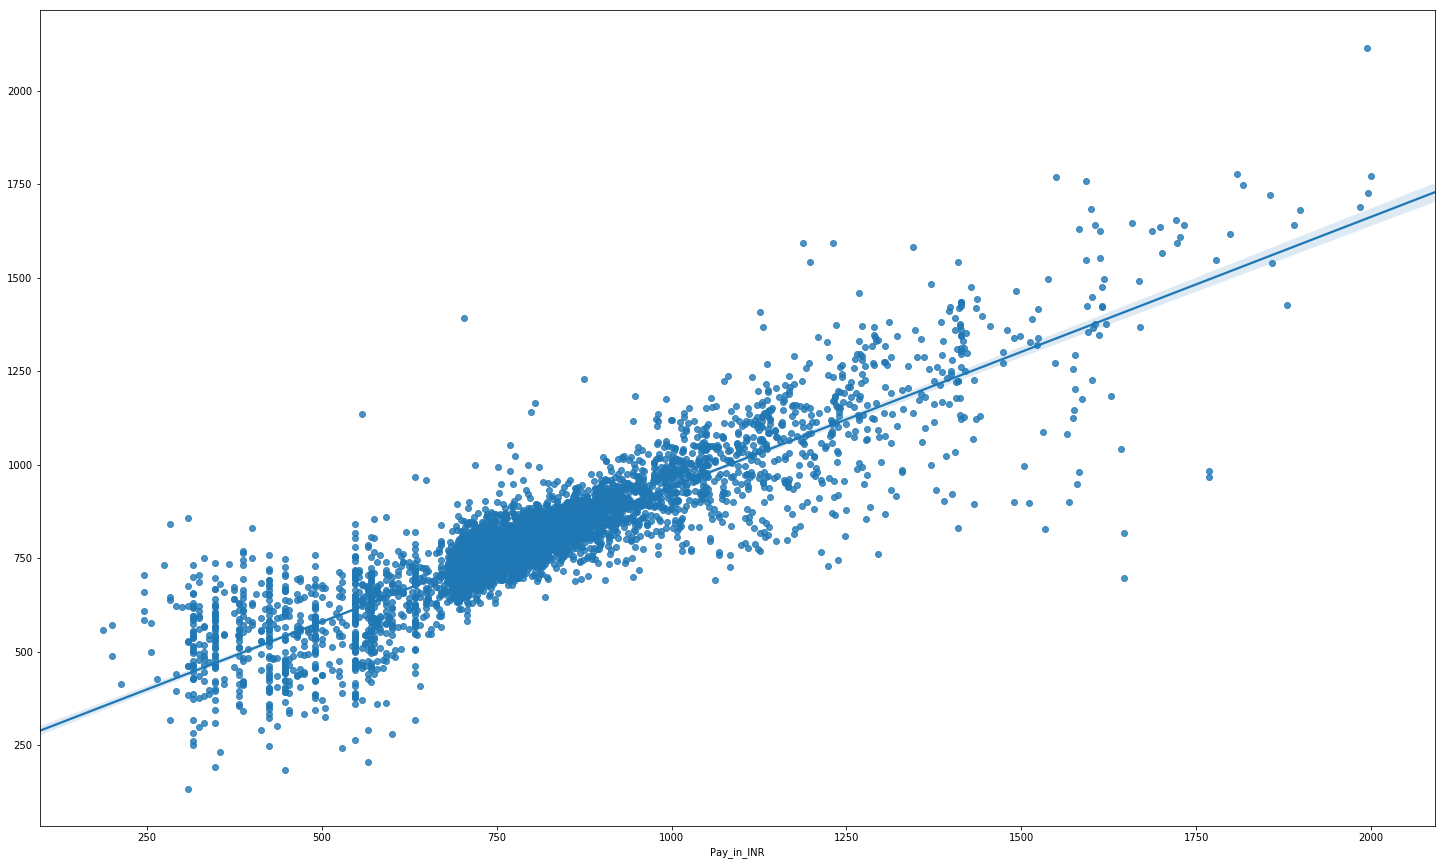

In [49]:
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15

sns.regplot(y_test,y_test_pred)

#### Considering with 'age_in_months'

In [50]:
# make predictions on unseen data
targetUnseenPred = xgb1.predict(unseenDataDF)

In [58]:
finalPredDF = pd.DataFrame()
finalPredDF['id'] = unseenDataId
finalPredDF['salary'] = targetUnseenPred #targetUnseenPred

## convert the log10 values of prediction into actual values of target
#finalPredDF['Salary'] = finalPredDF['Salary'].apply(lambda x: 10**x)

# if you have used a sqrt transform:
finalPredDF['salary'] = finalPredDF['salary'].apply(lambda x: x**2)

finalPredDF['salary'] = finalPredDF['salary'].astype('int64')

finalPredDF.head()

,id,salary
0,343523,338733
1,1027655,403411
2,874596,323969
3,963123,558121
4,350211,370791


In [59]:
## create the submission file

submissionDF = pd.read_csv("samplesubmission-1550224112775.csv")
submissionDF.drop(submissionDF.columns[1],axis=1,inplace=True)

submissionDF = submissionDF.merge(finalPredDF,how='left',left_on='ID',right_on='id',left_index=False,right_index=False)
submissionDF.drop(['id'],axis=1,inplace=True)
submissionDF.rename(columns={'salary':'Salary'},inplace=True)
submissionDF.head()

,ID,Salary
0,343523,338733
1,1027655,403411
2,874596,323969
3,963123,558121
4,350211,370791


In [60]:
from datetime import datetime as DateTime  # use this module just to get unique submission file names. See below
submissionFileName = "sanjyot_submission_xgbFinal_" + (str(DateTime.now().time())[0:8]).replace(':','-') + '.csv'
submissionDF.to_csv(submissionFileName,index=False)